In [135]:
!pip install scikit-learn pandas opendatasets matplotlib plotly seaborn numpy --quiet


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [231]:
import os
import pandas as pd
import opendatasets as od
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_error, accuracy_score

%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
plt.figure(figsize=(80,20))


<Figure size 8000x2000 with 0 Axes>

<Figure size 8000x2000 with 0 Axes>

In [232]:
# Download latest version
path = od.download("https://www.kaggle.com/c/rossmann-store-sales")

Skipping, found downloaded files in "./rossmann-store-sales" (use force=True to force download)


In [233]:
os.listdir('rossmann-store-sales')

['store.csv', 'train.csv', 'sample_submission.csv', 'test.csv']

In [234]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)

In [235]:
store_df = pd.read_csv('./rossmann-store-sales/store.csv')

In [236]:
merged_df = ross_df.merge(store_df, how='left', on='Store')

In [435]:
test_df = pd.read_csv('./rossmann-store-sales/test.csv')

In [436]:
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [209]:
round(merged_df.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.43,321.91,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,4.00,2.00,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.82,3849.93,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.15,464.41,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.83,0.38,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.38,0.49,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.18,0.38,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,1014567.0,5430.09,7715.32,20.0,710.0,2330.0,6890.0,75860.0
CompetitionOpenSinceMonth,693861.0,7.22,3.21,1.0,4.0,8.0,10.0,12.0
CompetitionOpenSinceYear,693861.0,2008.69,5.99,1900.0,2006.0,2010.0,2013.0,2015.0


In [210]:
#check for duplicate
merged_df.duplicated().sum()

np.int64(0)

In [296]:
merged_df.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268619
CompetitionOpenSinceYear     268619
Promo2                            0
Promo2SinceWeek              423307
Promo2SinceYear              423307
PromoInterval                423307
Day                               0
Month                             0
Year                              0
dtype: int64

In [288]:
merged_df.StateHoliday.value_counts()

StateHoliday
0    843482
a       694
b       145
c        71
Name: count, dtype: int64

<Axes: xlabel='Sales', ylabel='Count'>

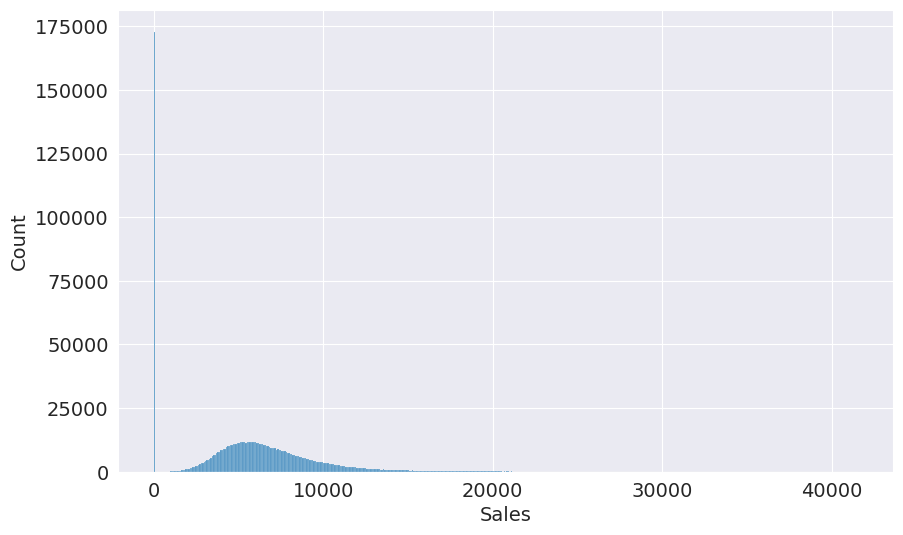

In [211]:
sns.histplot(data=merged_df, x='Sales')

In [212]:
# in this exercise we want to keep the data when they close
merged_df.Open.value_counts()

Open
1    844392
0    172817
Name: count, dtype: int64

In [239]:
# keeping Open = 0 is generating a big 0 predictions
merged_df = merged_df.loc[merged_df['Open'] == 1]
# change Date to timestamp
merged_df['Date'] = pd.to_datetime(merged_df.Date)

<Axes: xlabel='Sales', ylabel='Count'>

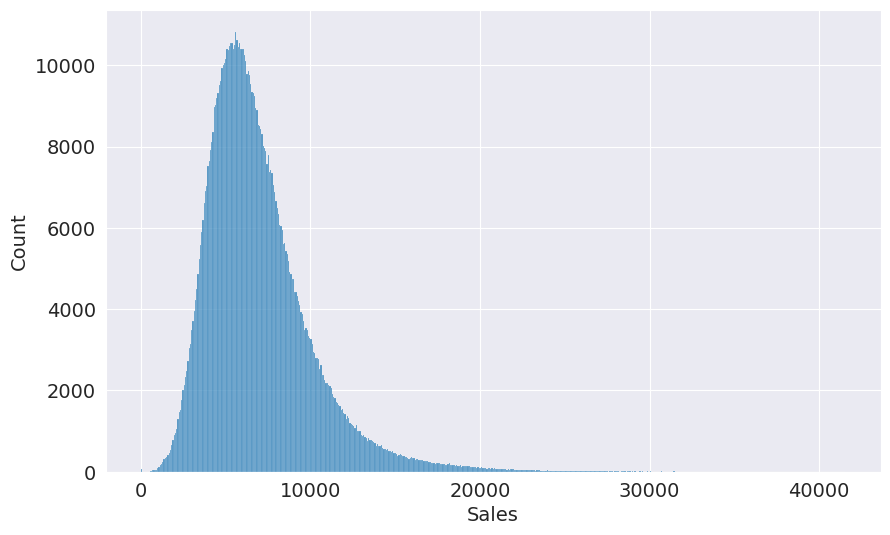

In [214]:
sns.histplot(data=merged_df, x='Sales')

<Axes: xlabel='DayOfWeek', ylabel='Sales'>

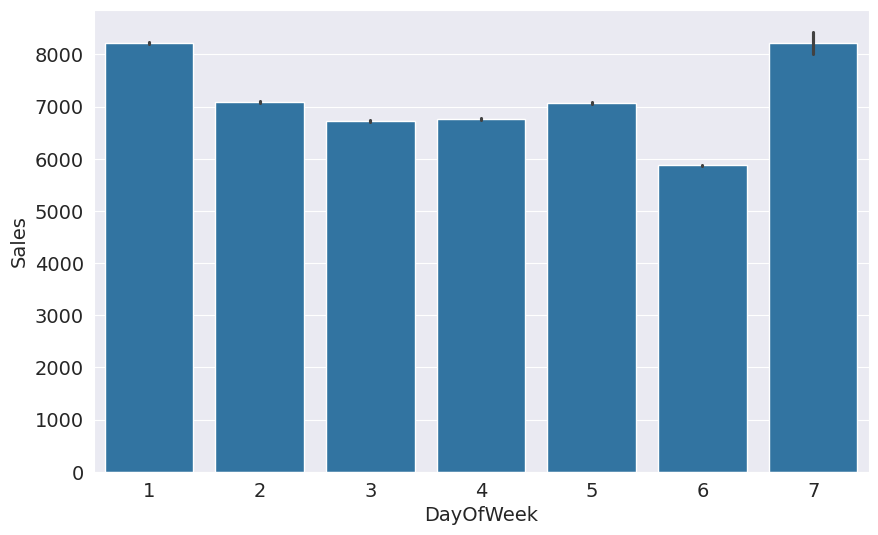

In [215]:
sns.barplot(data=merged_df, x='DayOfWeek', y='Sales')

<Axes: xlabel='Promo', ylabel='Sales'>

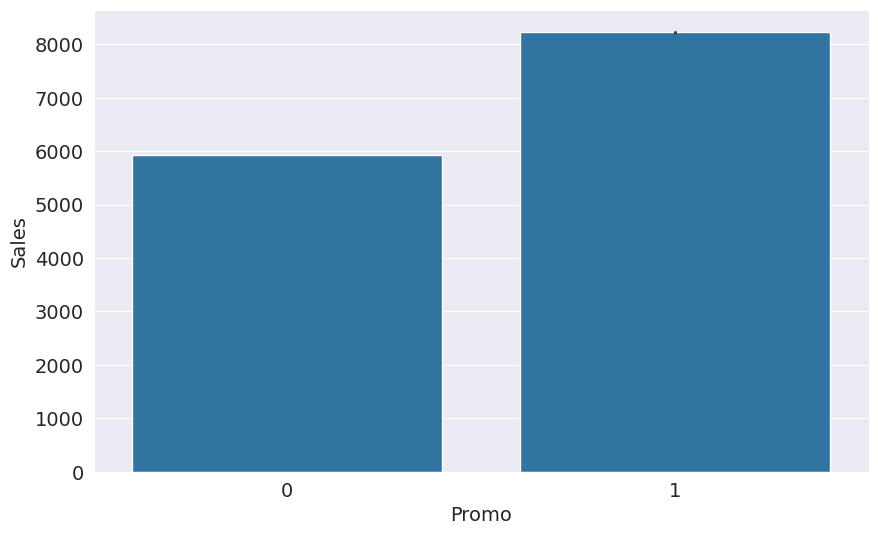

In [216]:
sns.barplot(data=merged_df, x='Promo', y='Sales')

In [217]:
merged_df.select_dtypes(include=np.number).corr()['Sales'].sort_values(ascending=False)

Sales                        1.000000
Customers                    0.823597
Promo                        0.368145
Promo2SinceWeek              0.095311
SchoolHoliday                0.038617
CompetitionOpenSinceYear     0.016101
Store                        0.007710
Promo2SinceYear             -0.034713
CompetitionDistance         -0.036396
CompetitionOpenSinceMonth   -0.043489
Promo2                      -0.127596
DayOfWeek                   -0.178736
Open                              NaN
Name: Sales, dtype: float64

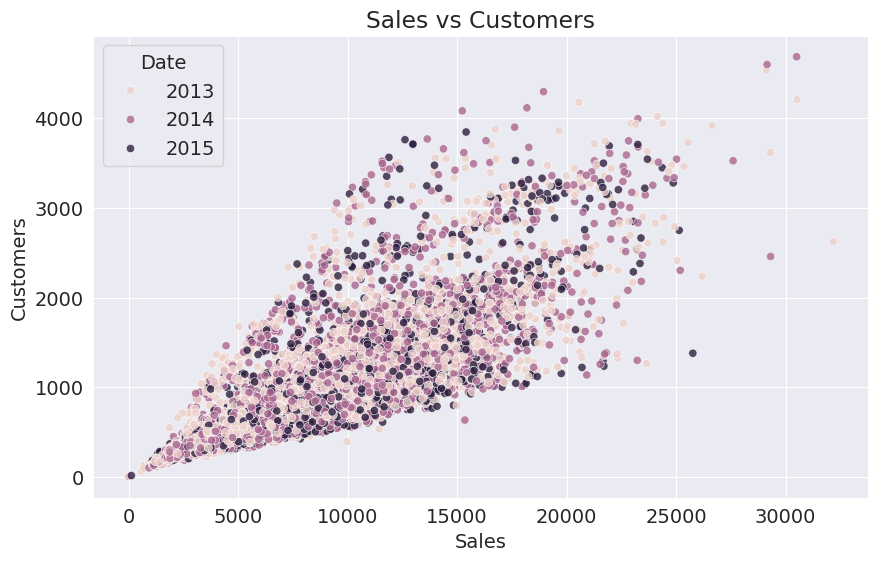

In [218]:
scatter_sample_df = merged_df.sample(40000)
sns.scatterplot(x=scatter_sample_df.Sales, y=scatter_sample_df.Customers, hue=scatter_sample_df.Date.dt.year, alpha=0.8)
plt.title('Sales vs Customers')
plt.show()

In [362]:
def prep_train_df(merged_df):
    # feature engineering, split date to day, month, and year
    merged_df['Date'] = pd.to_datetime(merged_df.Date)
    merged_df['Day'] = merged_df.Date.dt.day
    merged_df['Month'] = merged_df.Date.dt.month
    merged_df['Year'] = merged_df.Date.dt.year

    # drop Customers since its not in the test data
    merged_df = merged_df.drop(['Customers'], axis=1)

    # set aside data for validation
    # with this method we get 0.18 error
    train_size = int(.75 * len(merged_df))
    train_df, val_df = merged_df[:train_size], merged_df[train_size:]  

    # with this method we get 0.35 error
    # train_df, val_df = merged_df[merged_df.Date.dt.year <= 2014], merged_df[merged_df.Date.dt.year == 2015]

    # set the targets
    train_targets, val_targets = train_df['Sales'], val_df['Sales']
    
    # drop Sales since its the targets
    train_df, val_df = train_df.drop(['Sales'], axis=1), val_df.drop(['Sales'], axis=1)                 

    # drop column with large missing data
    # n_large_missing_data = [
    #     'Open','Promo2SinceWeek','Promo2SinceYear','CompetitionDistance',
    #     'CompetitionOpenSinceMonth','CompetitionOpenSinceYear'
    # ]
    # c_large_missing_data = ['PromoInterval','Assortment']
    n_large_missing_data = []
    c_large_missing_data = []
    numeric_cols = list(filter(
        lambda x: x not in n_large_missing_data, 
        train_df.select_dtypes(include=np.number).columns.tolist()
    ))
    categorical_cols = list(filter(
        lambda x: x not in c_large_missing_data, 
        train_df.select_dtypes('object').columns.tolist()
    ))

    return train_df, val_df, train_targets, val_targets, numeric_cols, categorical_cols

In [363]:
train_df, val_df, train_targets, val_targets, numeric_cols, categorical_cols = prep_train_df(merged_df)

<Axes: xlabel='Year', ylabel='Sales'>

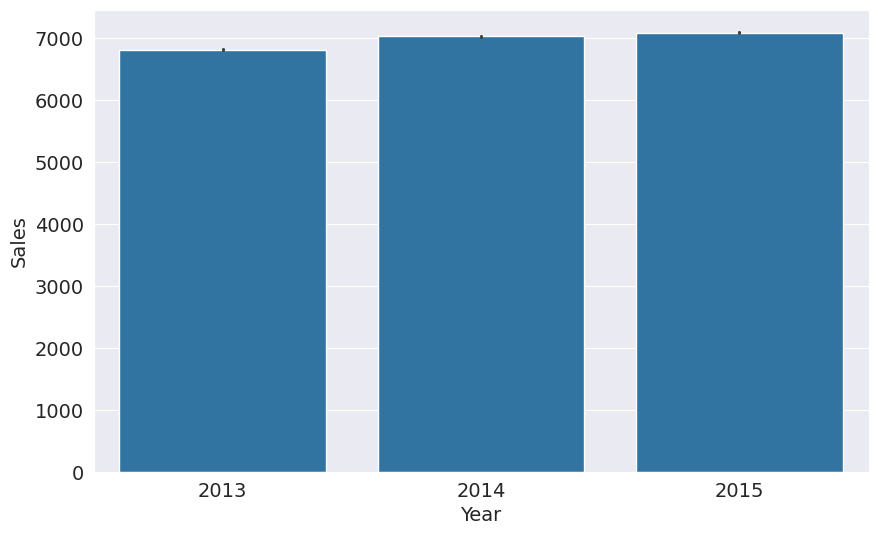

In [221]:
sns.barplot(data=merged_df, x='Year', y='Sales')

<Axes: xlabel='Month', ylabel='Sales'>

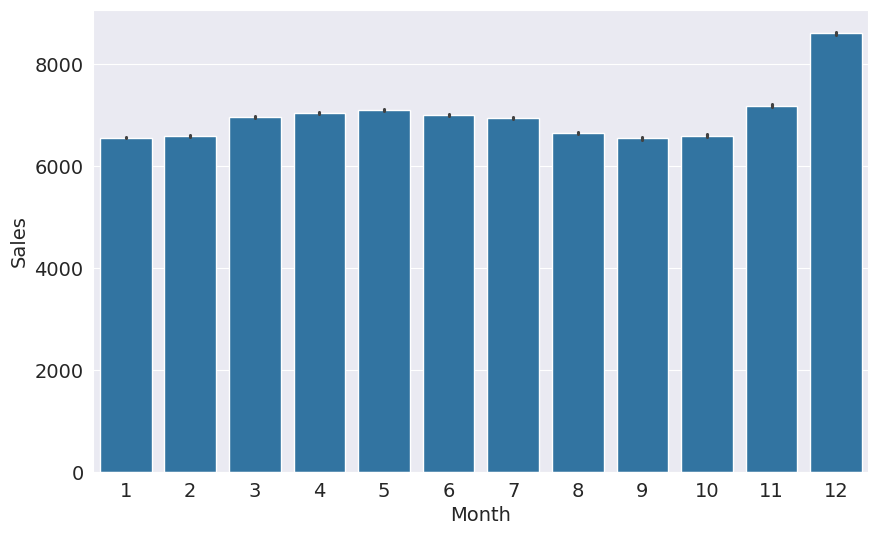

In [222]:
sns.barplot(data=merged_df, x='Month', y='Sales')

<Axes: xlabel='Day', ylabel='Sales'>

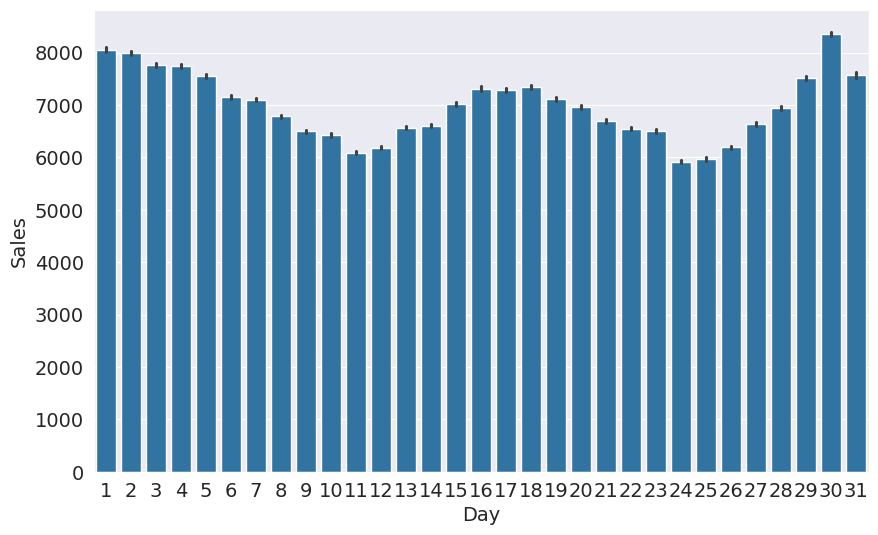

In [223]:
sns.barplot(data=merged_df, x='Day', y='Sales')

In [302]:
merged_df.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268619
CompetitionOpenSinceYear     268619
Promo2                            0
Promo2SinceWeek              423307
Promo2SinceYear              423307
PromoInterval                423307
Day                               0
Month                             0
Year                              0
dtype: int64

In [334]:
numeric_cols

['Store',
 'DayOfWeek',
 'Promo',
 'SchoolHoliday',
 'Promo2',
 'Day',
 'Month',
 'Year']

In [335]:
categorical_cols

['StateHoliday', 'StoreType']

In [276]:
train_df, val_df, train_targets, val_targets, numeric_cols, categorical_cols = prep_train_df(merged_df)

In [364]:
def enrich_train_df(train_df,val_df):
    # turn categorical features to numeric
    encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
    encoder.fit(train_df[categorical_cols])

    encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

    train_df[encoded_cols] = encoder.transform(train_df[categorical_cols])
    val_df[encoded_cols] = encoder.transform(val_df[categorical_cols])

    train_df = train_df[numeric_cols + encoded_cols]
    val_df = val_df[numeric_cols + encoded_cols]

    # fill missing data with imputation
    imputer = SimpleImputer(strategy = 'mean')
    imputer.fit(train_df)
    train_df = imputer.transform(train_df)
    imputer.fit(val_df)
    val_df = imputer.transform(val_df)
    
    #scale the values
    scaler = MinMaxScaler()  
    scaler.fit(train_df)
    train_df = scaler.transform(train_df)
    scaler.fit(val_df)
    val_df = scaler.transform(val_df)

    return train_df, val_df

In [365]:
train_df, val_df = enrich_train_df(train_df, val_df)

In [163]:
# setup benchmark with simple models
def return_mean(inputs):
    return np.full(len(inputs), merged_df.Sales.mean())

In [164]:
train_preds = return_mean(train_df)

In [165]:
train_preds

array([6955.51429076, 6955.51429076, 6955.51429076, ..., 6955.51429076,
       6955.51429076, 6955.51429076])

In [166]:
root_mean_squared_error(train_preds, train_targets)

np.float64(3133.6629394533265)

In [167]:
def guess_random(inputs):
    lo, hi = merged_df.Sales.min(), merged_df.Sales.max()
    return np.random.random(len(inputs)) * (hi - lo) + lo

In [168]:
train_preds = guess_random(train_df)

In [169]:
train_preds

array([35113.74386779, 15158.14204322,  9174.26782146, ...,
       18077.62116483, 39292.12119122, 19660.79227262])

In [170]:
root_mean_squared_error(train_preds, train_targets)

np.float64(18501.511845486904)

In [359]:
# baseline ML model
linreg = LinearRegression()

linreg.fit(train_df, train_targets)

LinearRegression()

In [360]:
linreg.score(train_df, train_targets)

0.18827746011608582

In [173]:
train_preds = linreg.predict(train_df)

In [120]:
train_preds

array([8393.43537994, 7497.36881185, 6755.41001842, ..., 7206.70390668,
       8481.65082744, 7748.65653849])

In [121]:
root_mean_squared_error(train_preds, train_targets)

np.float64(2809.70810010333)

In [357]:
def try_model(model, train_df, train_targets, val_df, val_targets):
    model.fit(train_df, train_targets)

    print(type(model).__name__ + ' train error: {}'.format(1 - model.score(train_df, train_targets)))
    
    train_preds = model.predict(train_df)

    print(type(model).__name__ + ' train - rmse: {}'.format(root_mean_squared_error(train_preds, train_targets)))
    
    print(type(model).__name__ + ' val error: {}'.format(1 - model.score(val_df, val_targets)))

    val_preds = model.predict(val_df)
    
    print(type(model).__name__ + ' val - rmse: {}'.format(root_mean_squared_error(val_preds, val_targets)))

In [181]:
for mdl in [LinearRegression(), Ridge(), Lasso(), ElasticNet(), SGDRegressor()]:
    try_model(mdl, train_df, train_targets, val_df, val_targets)

LinearRegression train error: 0.8044553251419233
LinearRegression train - rmse: 2809.70810010333
LinearRegression val error: 32.93980306378352
LinearRegression val - rmse: 17243.986489315175
Ridge train error: 0.8045051489993137
Ridge train - rmse: 2809.7951082464833
Ridge val error: 1.9310716083241808
Ridge val - rmse: 4175.191157519673
Lasso train error: 0.8049525938381529
Lasso train - rmse: 2810.576367111089
Lasso val error: 0.8404560399674217
Lasso val - rmse: 2754.4486222619635
ElasticNet train error: 0.8946757272572056
ElasticNet train - rmse: 2963.077874309573
ElasticNet val error: 0.9062493385477756
ElasticNet val - rmse: 2860.2304513749773
SGDRegressor train error: 0.8048193280527445
SGDRegressor train - rmse: 2810.3437017506144
SGDRegressor val error: 0.8233517224091551
SGDRegressor val - rmse: 2726.276336023251


In [182]:
try_model(DecisionTreeRegressor(random_state=42), train_df, train_targets, val_df, val_targets)

DecisionTreeRegressor train error: 0.0
DecisionTreeRegressor train - rmse: 0.0
DecisionTreeRegressor val error: 0.2808255558236632
DecisionTreeRegressor val - rmse: 1592.19218639504


In [184]:
try_model(RandomForestRegressor(random_state=42, n_jobs=-1), train_df, train_targets, val_df, val_targets)
# try_model(RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=20), train_df, train_targets, val_df, val_targets)

RandomForestRegressor train error: 0.011471760272063092
RandomForestRegressor train - rmse: 335.5252970293311
RandomForestRegressor val error: 0.19888620451401184
RandomForestRegressor val - rmse: 1339.9219595426132


In [286]:
def test_rf_params(param_name, param_value, train_df, train_targets, val_df, val_targets):
    params = {param_name :param_value}
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(train_df, train_targets)
    train_acc = 1 - model.score(train_df, train_targets)
    val_acc = 1 - model.score(val_df, val_targets)
    print('Param Name: {param_name},Param Value: {param_value},Training Error: {train_acc},Validation Error: {val_acc}'.format(
        param_name=param_name, param_value=param_value, train_acc=train_acc, val_acc=val_acc
    ))
    return {'Param Name' : param_name, 'Param Value' : param_value, 'Training Error': train_acc, 'Validation Error': val_acc}

In [341]:
%%time
# params = [{'name': 'n_estimators','value':val} for val in range(16,60,2)]
params = [{'name': 'n_estimators','value':val} for val in [100]]
errors_df = pd.DataFrame(
    [
        test_rf_params(param['name'], param['value'], train_df, train_targets, val_df, val_targets) 
        for param in params
    ]
)

Param Name: n_estimators,Param Value: 100,Training Error: 0.02332536108875083,Validation Error: 0.3549924042552399
CPU times: user 12min 10s, sys: 13.1 s, total: 12min 23s
Wall time: 3min 29s


In [283]:
errors_df

,Param Name,Param Value,Training Error,Validation Error
0,n_estimators,30,0.013691,0.180611
1,n_estimators,32,0.013580,0.180903
2,n_estimators,34,0.013463,0.180638
3,n_estimators,36,0.013376,0.180319
4,n_estimators,38,0.013303,0.180267
5,n_estimators,40,0.013223,0.180122
6,n_estimators,42,0.013140,0.180090
7,n_estimators,44,0.013063,0.180323
8,n_estimators,46,0.013003,0.180679
9,n_estimators,48,0.012943,0.180555


In [366]:
# model = DecisionTreeRegressor(random_state = 42)
model = RandomForestRegressor(random_state=42, n_jobs=-1)
# model = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=20)
# model = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=61, min_impurity_decrease=1e-12)
model.fit(train_df, train_targets)

print('train acc: {}'.format(1 - model.score(train_df, train_targets)))
    
train_preds = model.predict(train_df)

print('train - rmse: {}'.format(root_mean_squared_error(train_preds, train_targets)))
    
print('val acc: {}'.format(1 - model.score(val_df, val_targets)))

val_preds = model.predict(val_df)
    
print('val - rmse: {}'.format(root_mean_squared_error(val_preds, val_targets)))

train acc: 0.012334151100525714
train - rmse: 347.90836451407955
val acc: 0.1802360802349059
val - rmse: 1275.5516287571413


In [437]:
def prep_test_df(merged_test_df):
    # feature engineering, split date to day, month, and year
    submit_test_df = merged_test_df.copy()
    submit_test_df['Date'] = pd.to_datetime(submit_test_df.Date)
    submit_test_df['Day'] = submit_test_df.Date.dt.day
    submit_test_df['Month'] = submit_test_df.Date.dt.month
    submit_test_df['Year'] = submit_test_df.Date.dt.year

    # drop column with large missing data
    # n_large_missing_data = [
    #     'Open','Promo2SinceWeek','Promo2SinceYear','CompetitionDistance',
    #     'CompetitionOpenSinceMonth','CompetitionOpenSinceYear'
    # ]
    # c_large_missing_data = ['PromoInterval','Assortment']
    n_large_missing_data = ['Id']
    c_large_missing_data = []
    numeric_cols = list(filter(
        lambda x: x not in n_large_missing_data, 
        submit_test_df.select_dtypes(include=np.number).columns.tolist()
    ))
    categorical_cols = list(filter(
        lambda x: x not in c_large_missing_data, 
        submit_test_df.select_dtypes('object').columns.tolist()
    ))
    
    return submit_test_df, numeric_cols, categorical_cols

In [438]:
submit_test_df, numeric_cols, categorical_cols = prep_test_df(merged_test_df)

In [439]:
numeric_cols

['Store',
 'DayOfWeek',
 'Open',
 'Promo',
 'SchoolHoliday',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'Day',
 'Month',
 'Year']

In [440]:
categorical_cols

['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']

In [441]:
merged_test_df.isna().sum()

Id                               0
Store                            0
DayOfWeek                        0
Date                             0
Open                            11
Promo                            0
StateHoliday                     0
SchoolHoliday                    0
StoreType                        0
Assortment                       0
CompetitionDistance             96
CompetitionOpenSinceMonth    15216
CompetitionOpenSinceYear     15216
Promo2                           0
Promo2SinceWeek              17232
Promo2SinceYear              17232
PromoInterval                17232
dtype: int64

In [442]:
# test has only 0 and a, so just edit the file to change the first couple with b and c
submit_test_df.StateHoliday.value_counts()

StateHoliday
0    40906
a      180
c        1
b        1
Name: count, dtype: int64

In [443]:
submit_test_df.isna().sum()

Id                               0
Store                            0
DayOfWeek                        0
Date                             0
Open                            11
Promo                            0
StateHoliday                     0
SchoolHoliday                    0
StoreType                        0
Assortment                       0
CompetitionDistance             96
CompetitionOpenSinceMonth    15216
CompetitionOpenSinceYear     15216
Promo2                           0
Promo2SinceWeek              17232
Promo2SinceYear              17232
PromoInterval                17232
Day                              0
Month                            0
Year                             0
dtype: int64

In [444]:
def enrich_test_df(submit_test_df):
    # turn categorical features to numeric
    encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
    encoder.fit(submit_test_df[categorical_cols])

    encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

    submit_test_df[encoded_cols] = encoder.transform(submit_test_df[categorical_cols])
    
    submit_test_df = submit_test_df[numeric_cols + encoded_cols]

    # fill missing data with imputation
    imputer = SimpleImputer(strategy = 'mean')
    imputer.fit(submit_test_df)
    submit_test_df = imputer.transform(submit_test_df)
    
    #scale the values
    scaler = MinMaxScaler()  
    scaler.fit(submit_test_df)
    submit_test_df = scaler.transform(submit_test_df)

    return submit_test_df

In [445]:
X_inputs = enrich_test_df(submit_test_df)

In [446]:
test_preds = model.predict(X_inputs)
test_preds

array([ 7483.83, 11715.3 , 12570.15, ...,  5735.89, 21429.03,  6283.27])

In [447]:
test_preds_df = pd.DataFrame(test_preds, columns=['Sales'])

In [448]:
test_preds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   41088 non-null  float64
dtypes: float64(1)
memory usage: 321.1 KB


In [449]:
merged_test_df['Sales'] = test_preds_df['Sales']

In [450]:
merged_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Date                       41088 non-null  object 
 4   Open                       41077 non-null  float64
 5   Promo                      41088 non-null  int64  
 6   StateHoliday               41088 non-null  object 
 7   SchoolHoliday              41088 non-null  int64  
 8   StoreType                  41088 non-null  object 
 9   Assortment                 41088 non-null  object 
 10  CompetitionDistance        40992 non-null  float64
 11  CompetitionOpenSinceMonth  25872 non-null  float64
 12  CompetitionOpenSinceYear   25872 non-null  float64
 13  Promo2                     41088 non-null  int

In [451]:
merged_test_df.Sales.isna().sum()

np.int64(0)

In [452]:
submission_df  = pd.read_csv('./rossmann-store-sales/sample_submission.csv')

In [453]:
submission_df['Sales'] = merged_test_df['Open'].fillna(1).astype('int') * test_preds

In [454]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      41088 non-null  int64  
 1   Sales   41088 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 642.1 KB


In [455]:
submission_df.Id.isna().sum()

np.int64(0)

In [456]:
submission_df.Sales.isna().sum()

np.int64(0)

In [457]:
submission_df.Sales.value_counts()

Sales
0.00       5984
5532.15       3
6191.96       3
5920.73       3
5136.78       3
           ... 
9012.82       1
9126.57       1
8776.40       1
6857.62       1
7666.57       1
Name: count, Length: 34478, dtype: int64

In [458]:
submission_df.to_csv('submission.csv', index=None)

In [459]:
!head submission.csv

Id,Sales
1,7483.83
2,11715.3
3,12570.15
4,8656.44
5,9307.88
6,7621.44
7,17648.02
8,12233.88
9,8610.23
